In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-rwrn0sr4
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-rwrn0sr4
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80071 sha256=52bdc5edc13a6233bf007431cd81aac7f01ddffc0b2e0a61eeae9f9a17c5c9e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-9zyqtm5h/wheels/73/f4/42/d2b85ca46d85a241d6aa57c1c24027de2d2258202bb67945f9
Successfully built d2l


# 网络中的网络（NiN）

## (**NiN块结构**)

![对比 VGG 和 NiN 及它们的块之间主要架构差异。](http://d2l.ai/_images/nin.svg)
:width:`600px`
:label:`fig_nin`


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#定义NiN块
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## [**NiN模型**]

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),       #全局平均池化，高宽都变成1
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

**demo测试，查看每个块的输出情况**


In [4]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


**训练模型**

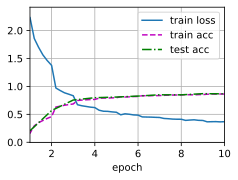

In [5]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())